In [19]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('../modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

## Create dataset

In [3]:
priors = [0.7, 0.3]

In [4]:
class1_gen = norm(loc=-1, scale=0.5)
class2_gen = norm(loc=1, scale=0.5)
gens = [class1_gen, class2_gen]

In [5]:
class1_xs = class1_gen.rvs(int(50000 * priors[0]))
class2_xs = class2_gen.rvs(int(50000 * priors[1]))

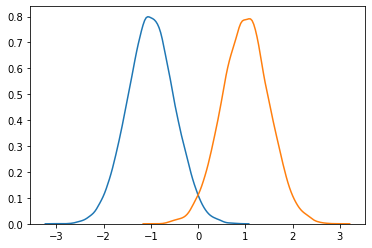

In [6]:
sns.kdeplot(class1_xs)
sns.kdeplot(class2_xs)
plt.show()

## Prediction using Bayes' rule

In [43]:
def p_class_given_x(klass, x):
    return (gens[klass].pdf(x) * priors[klass]) / (gens[0].pdf(x) * priors[0] + gens[1].pdf(x) * priors[1])

In [44]:
xs = np.linspace(-3, 3, 100)
likelihoods_c2 = [gens[1].pdf(x) for x in xs]
posteriors_c2 = [p_class_given_x(klass=1, x=x) for x in xs]

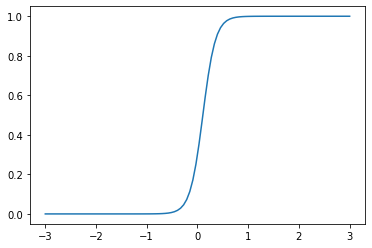

In [45]:
plt.plot(xs, posteriors_c2)
plt.show()

## Prepare dataset for neural network

In [10]:
all_xs = np.vstack([class1_xs.reshape(-1, 1), class2_xs.reshape(-1, 1)])
all_ys = np.vstack([np.zeros((len(class1_xs), 1)), np.ones((len(class2_xs), 1))])

In [11]:
def train_test_split(xs, ys, train_prop):
    train_num = int(train_prop * len(xs))
    idxs = np.arange(len(xs))
    np.random.shuffle(idxs)
    train_idxs, valid_idxs = sorted(idxs[:train_num]), sorted(idxs[train_num:])
    return (xs[train_idxs], ys[train_idxs]), (xs[valid_idxs], ys[valid_idxs])

In [12]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(all_xs, all_ys, train_prop=0.8)

In [13]:
x_train, y_train, x_valid, y_valid = map(torch.Tensor, [x_train, y_train, x_valid, y_valid])

In [14]:
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)
train_dl, valid_dl = DataLoader(train_ds, batch_size=64, shuffle=True), DataLoader(valid_ds, batch_size=128)

## Train neural network

In [15]:
class NN(nn.Module):
    
    def __init__(self, num_layers):
        
        super().__init__()
        
        input_layer = [nn.Linear(1, 64), nn.ReLU()]
        hidden_layers = []
        for i in range(num_layers):
            hidden_layers.append(nn.Linear(64, 64))
            hidden_layers.append(nn.ReLU())
        output_layer = [nn.Linear(64, 1)]
        
        self.network = nn.ModuleList(input_layer + hidden_layers + output_layer)
        
    def forward(self, xs):
        for l in self.network:
            xs = l(xs)
        return xs

In [16]:
def get_model(num_components):
    nn = NN(num_layers=3)
    return nn, optim.Adam(nn.parameters(), lr=0.01)

In [17]:
def sum_of_squares(yhats, ys):
    return torch.sum((yhats - ys) ** 2)

In [21]:
num_components = 4

model, opt = get_model(num_components)
learn = Learner(train_dl, valid_dl, model, sum_of_squares, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

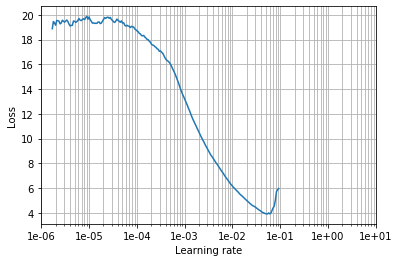

In [23]:
trainer.find_lr(beta=0.98, final_value=10, num_itr=300)

In [24]:
trainer.set_lr(7e-4)
trainer.train(num_epoch=5)

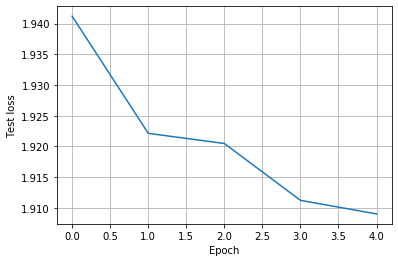

In [25]:
loss_cb.plot()
plt.show()

In [58]:
# trainer.save_as_pth('sum_of_squares_error_function_model_posterior_probabilities.pth')

In [63]:
trainer.load_from_pth('sum_of_squares_error_function_model_posterior_probabilities.pth')

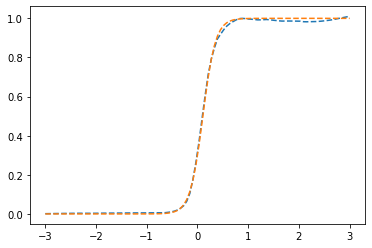

In [64]:
plt.plot(
    np.linspace(-3, 3, 100), 
    model(torch.Tensor(np.linspace(-3, 3, 100).reshape(-1, 1))).detach().numpy().flatten(),
    '--'
)
plt.plot(xs, posteriors_c2, '--')
plt.show()

In [65]:
np.max(model(torch.Tensor(np.linspace(-3, 3, 100).reshape(-1, 1))).detach().numpy().flatten())

1.0107701